# **Task 1 | GPT-2 Model & Checkpoints**

GPT2-small model (with 125 million parameters) utilizes a 12-layer Decoder Only Transformer Architecture.

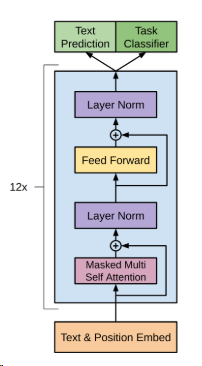


As can be seen from the GPT Architecture, to implement it, we will first need to implement Layer Norm, Masked Multi Self Attention and Feed Forward layer.

In [ ]:
import torch.nn as nn
import torch
import copy
import math
import numpy as np
import torch.nn.functional as F

from torch.nn.parameter import Parameter
from torch.nn.modules import ModuleList
from dataclasses import dataclass



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class LayerNorm(nn.Module):

    def __init__(self, hidden_size, epsilon=1e-12):
      """
      Initialize LayerNorm module.
      """
      super().__init__()

      # Learnable weight parameter for scaling.
      self.weight = nn.Parameter(torch.ones(hidden_size))

      # Learnable bias parameter for shifting.
      self.bias = nn.Parameter(torch.zeros(hidden_size))

      # Small value to avoid division by zero in normalization.
      self.epsilon = epsilon

    def forward(self, x):

      # Compute mean and variance along the last dimension.
      u = x.mean(-1, keepdim=True)
      s = (x - u).pow(2).mean(-1, keepdim=True)

      # Normalize the input tensor.
      x = (x - u) / torch.sqrt(s + self.epsilon)

      # Scale and shift using learnable parameters.
      return self.weight * x + self.bias

To split the query, key and value matrices successfully for the Attention Layer, we use CONV1D layer that returns the tensor's dimension to be 3 times of the initial size.

In [ ]:
class Conv1D(nn.Module):
    def __init__(self, nx, nf):
        '''
        nx: Number of input features.
        nf: Number of filters (output channels).
        '''
        super().__init__()
        self.nf = nf
        #intialising an empty matrix as weights for size of (nx)X(nf)
        w = torch.empty(nx, nf)
        #initialising these weights as normal distribution
        nn.init.normal_(w, std=0.02)
        #calculating the weights and biases by encoding them using nn.Parameter
        self.weight = nn.Parameter(w)
        self.bias = nn.Parameter(torch.zeros(nf))

    def forward(self, x):
        '''x:The input tensor'''
        #this size output is summation of x second dimension and the nf dimension
        size_out = x.size()[:-1] + (self.nf,)
        # dot multiplying Q,K(transpose) and V
        x = torch.addmm(self.bias, x.view(-1, x.size(-1)), self.weight)#x.view helps in taking the transpose out
        x = x.view(*size_out)
        return x

In [ ]:
d_model = 768
conv1d  = Conv1D(d_model, d_model*3)
x = torch.rand(1,4,d_model) # A random input tensor for testing out our model
x = conv1d(x)

query, key, value = x.split(d_model, dim=-1)# here we can split our output attention into quey, key and value

query.shape, key.shape, value.shape

(torch.Size([1, 4, 768]), torch.Size([1, 4, 768]), torch.Size([1, 4, 768]))

The Feedforward network, is a normal neural network that accepts the outputs from the ATTENTION layer (768), casts them to nx (768*4) dimension, adds an activation function self.act (GELU), casts them back to d_model (768) and adds dropout regularization(0.1).

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, dropout, d_model=768, nx=768*4):
        super().__init__()
        self.c_fc    = Conv1D(d_model, nx)
        self.c_proj  = Conv1D(nx, d_model)
        self.act     = F.gelu
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.dropout(self.c_proj(self.act(self.c_fc(x))))

Scaled Dot-Product Attention: The attention is a function of a query (Q) and set of key (K) and value (V) pairs. To handle longer sequences, we modify the multi-head self-attention of the Transformer to reduce memory usage by limiting the dot products between Q and K in:

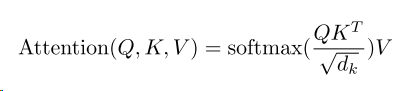

where dk is dimension



Multi-head Attention: It is a module for attention mechanisms which runs through an attention mechanism several times in parallel. The independent attention outputs are then concatenated and linearly transformed into the expected dimension.

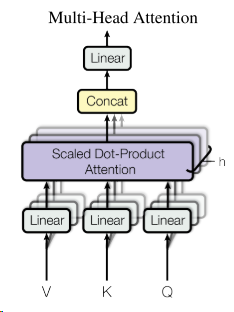

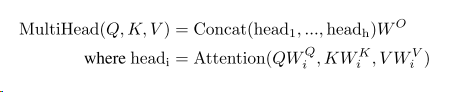




In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model=768, n_head=12, n_ctx=1024, d_head=64, bias=True, scale=False):
        '''Constructor funtion
        Params:
        d_model:The dimension that needs to be feed into our model
        n_head:The number of heads for attention
        n_ctx:a parameters for buffer registry for bias
        d_head:the dimension head output
        bias:A bool for including or not including bias
        scale: Whether to scale the attention scores by the square root of the dimension of the queries(use sqrt(dk) or not) "
        '''
        super().__init__()
        self.n_head  = n_head
        self.d_model = d_model
        self.c_attn  = Conv1D(d_model, d_model*3)
        self.scale   = scale
        self.softmax = nn.Softmax(dim=-1)
        self.register_buffer("bias", torch.tril(torch.ones(n_ctx, n_ctx)).view(1, 1, n_ctx, n_ctx))
        self.dropout = nn.Dropout(0.1)
        self.c_proj  = Conv1D(d_model, d_model)

    def split_heads(self, x):
        """
        spliting inyo given number of heads and then returning
        return shape [`batch`, `head`, `sequence`, `features`]
        """
        new_shape = x.size()[:-1] + (self.n_head, x.size(-1)//self.n_head)
        x = x.view(*new_shape)
        return x.permute(0, 2, 1, 3)

    def _attn(self, q, k, v, attn_mask=None):
        """The main attention function
        That claculates the attention using our dot product formula"""
        scores  = torch.matmul(q, k.transpose(-2, -1))# dot multiplication between q and k transpose
        if self.scale: scores = scores/math.sqrt(v.size(-1))# scaling it by dividing by sqrt(dk)
        nd, ns  = scores.size(-2), scores.size(-1)
        if attn_mask is not None: scores = scores + attn_mask# adding scores with attention mask values
        scores  = self.softmax(scores)# adding softmax values
        scores  = self.dropout(scores) #dropout of 0.1 as mentioned
        outputs = torch.matmul(scores, v) # now the final matrix multiplication between score and V
        return outputs

    def merge_heads(self, x):
        # merging the attention heads into one
        x = x.permute(0, 2, 1, 3).contiguous()
        new_shape = x.size()[:-2] + (x.size(-2)*x.size(-1),)
        return x.view(*new_shape)

    def forward(self, x):
        '''The feed forward function that calculates the attention, split the heads, make attention, merge heads and project out the output '''
        x        = self.c_attn(x) #new `x` shape - `[1,3,2304]`
        q, k, v  = x.split(self.d_model, dim=2)
        q, k, v  = self.split_heads(q), self.split_heads(k), self.split_heads(v)
        out      = self._attn(q, k, v)
        out      = self.merge_heads(out)
        out      = self.c_proj(out)
        return out

Inside a Transformer Decoder Block, we first pass the inputs to a LayerNorm followed by the first sub-block Attention. Next, we pass the outputs of this sub-block to LayerNorm again and finally to FeedForward layer.

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model=768, n_head=12, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.attn        = MultiHeadAttention(d_model=768, n_head=12, d_head=64, n_ctx=1024, bias=True, scale=False)
        self.feedforward = FeedForward(dropout=0.1, d_model=768, nx=768*4)
        self.ln_1        = LayerNorm(d_model)
        self.ln_2        = LayerNorm(d_model)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.feedforward(self.ln_2(x))
        return x

Below function is to create 12 layers.

In [ ]:
def _get_clones(module, n):
    '''Here we can make certain copies of transformers'''
    return ModuleList([copy.deepcopy(module) for i in range(n)])

Now we will build our GPT2 Model by putting together the above implementation.

In [ ]:
class GPT2(nn.Module):
    def __init__(self, nlayers=12, n_ctx=1024, d_model=768, vcb_sz=50257):
        '''nlayer:The number of times the tarnsformer needs to get cloned
        n_ctx:The highest length that can be these to get teh string positional embeddings
        d_model:The dimenionalities for model
        vcb_sz:The vocablury size which can be later altered while training'''
        super(GPT2, self).__init__()
        self.nlayers = nlayers
        block        = TransformerBlock(d_model=768, n_head=12, dropout=0.1)
        self.h       = _get_clones(block, 12)
        self.wte     = nn.Embedding(vcb_sz, d_model)
        self.wpe     = nn.Embedding(n_ctx, d_model)
        self.drop    = nn.Dropout(0.1)
        self.ln_f    = LayerNorm(d_model)
        self.out     = nn.Linear(d_model, vcb_sz, bias=False)
        self.loss_fn = nn.CrossEntropyLoss()
        self.init_weights()

    def init_weights(self):
        '''Initialization of weights'''
        self.out.weight = self.wte.weight
        self.apply(self._init_weights)

    def _init_weights(self, module):
        '''If the Linear, Embedding and Conv1D then nomrally initializing with mean and S.D'''
        if isinstance(module, (nn.Linear, nn.Embedding, Conv1D)):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if isinstance(module, (nn.Linear, Conv1D)) and module.bias is not None:
                '''Data Bias zero'''
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def forward(self, src, labels=None, pos_ids=None):
        '''Adding the positional embedding, dropping, then adding inputs, logits and outputs which are being used for loss function and then adding outputs and loss'''
        if pos_ids is None:
            pos_ids = torch.arange(0, src.size(-1)).unsqueeze(0)
        pos_ids = pos_ids.to(src.device)  # Ensure pos_ids is on the same device as src
        inp = self.drop((self.wte(src) + self.wpe(pos_ids)))
        for i in range(self.nlayers): inp = self.h[i](inp)
        inp     = self.ln_f(inp)
        logits  = self.out(inp)
        outputs = (logits,) + (inp,)

        if labels is not None:
            shift_logits = logits[..., :-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()
            loss = self.loss_fn(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
            outputs = (loss,) + outputs
            return loss.mean()
        return logits



**Inference: We are loading the original GPT-2 125M model checkpoints and running a sample prediction.**

---



In [ ]:
# loading pretrained_weights from hugging face`.`

!wget https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-pytorch_model.bin .

--2023-12-17 15:09:21--  https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-pytorch_model.bin
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.26.230, 54.231.137.248, 54.231.233.64, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.26.230|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 548118077 (523M) [application/octet-stream]
Saving to: ‘gpt2-pytorch_model.bin’

gpt2-pytorch_model. 100%[===================>] 522.73M  37.9MB/s    in 14s     

2023-12-17 15:09:34 (38.5 MB/s) - ‘gpt2-pytorch_model.bin’ saved [548118077/548118077]

--2023-12-17 15:09:34--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2023-12-17 15:09:34--
Total wall clock time: 14s
Downloaded: 1 files, 523M in 14s (38.5 MB/s)


In [ ]:
model = GPT2()
# load pretrained_weights from hugging face

model_dict = model.state_dict() #currently with random initialization
state_dict = torch.load("/content/gpt2-pytorch_model.bin") #pretrained weights

old_keys = []
new_keys = []
for key in state_dict.keys():
    if "mlp" in key: #The hugging face state dict references the feedforward network as mlp, need to replace to `feedforward` be able to reuse these weights
        new_key = key.replace("mlp", "feedforward")
        new_keys.append(new_key)
        old_keys.append(key)

for old_key, new_key in zip(old_keys, new_keys):
    state_dict[new_key]=state_dict.pop(old_key)

pretrained_dict = {k: v for k, v in state_dict.items() if k in model_dict}

model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)
model.eval() #model in inference mode as it's now initialized with pretrained weights

GPT2(
  (h): ModuleList(
    (0-11): 12 x TransformerBlock(
      (attn): MultiHeadAttention(
        (c_attn): Conv1D()
        (softmax): Softmax(dim=-1)
        (dropout): Dropout(p=0.1, inplace=False)
        (c_proj): Conv1D()
      )
      (feedforward): FeedForward(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_1): LayerNorm()
      (ln_2): LayerNorm()
    )
  )
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (ln_f): LayerNorm()
  (out): Linear(in_features=768, out_features=50257, bias=False)
  (loss_fn): CrossEntropyLoss()
)

In [ ]:
from transformers import GPT2LMHeadModel,GPT2Tokenizer
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2")

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

Comparing our model architecture with the GPT2LMHeadModel architecture:

In [ ]:
gpt2_num_params = sum(p.numel() for p in gpt2_model.parameters())
demo_num_params = sum(p.numel() for p in model.parameters())

if gpt2_num_params != demo_num_params:
    print("Model architectures do not match.")
    print(f"GPT-2 Model Parameters: {gpt2_num_params}")
    print(f"Your DemoTransformer Model Parameters: {demo_num_params}")
else:
    print("Model architectures match.")


Model architectures match.


Inference of GPT2 model built from scratch

In [ ]:
from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
context   = torch.tensor([tokenizer.encode("Hi, Contlo")])

def generate(context, ntok=20):
    for _ in range(ntok):
        out = model(context)
        logits = out[:, -1, :]
        indices_to_remove = logits < torch.topk(logits, 10)[0][..., -1, None]
        logits[indices_to_remove] = np.NINF
        next_tok = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1).squeeze(1)
        context = torch.cat([context, next_tok.unsqueeze(-1)], dim=-1)
    return context

out = generate(context, ntok=20)
tokenizer.decode(out[0])

'Hi, Contloat" or Loathing Never will be the " or" the will or "at them and the'

Inference of GPT2LMHeadModel

In [ ]:
input_text = "Hi,Contlo"
input_ids = tokenizer.encode(input_text, return_tensors='pt')

output = gpt2_model.generate(input_ids, max_length=50, num_beams=5, no_repeat_ngram_size=2, top_k=50)
output_text = tokenizer.decode(output[0], skip_special_tokens=True)

print("Input:", input_text)
print("Output:", output_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Input: Hi,Contlo
Output: Hi,Contlo. I'm sorry for the inconvenience, but I can't do anything about it.

Thank you for your patience and understanding.
